In [27]:
import numpy as np
import deepchem as dc
import numpy as np
from deepchem.feat import GraphData
import pandas as pd
from deepchem.feat import DMPNNFeaturizer
import deepchem as dc
from openpom.models.mpnn_pom import MPNNPOMModel

In [28]:
def get_graphs(weighted_adj_matrix):
    node_features = weighted_adj_matrix.diagonal().reshape(-1, 1)
    edges = np.array(np.nonzero(weighted_adj_matrix))
    edge_weights = weighted_adj_matrix[edges.T[:, 0], edges.T[:, 1]]
    graph = GraphData(node_features=node_features, edge_index=edges, edge_features=edge_weights.reshape(-1, 1))
    return graph

In [29]:
TASKS = [
'alcoholic', 'aldehydic', 'alliaceous', 'almond', 'amber', 'animal',
'anisic', 'apple', 'apricot', 'aromatic', 'balsamic', 'banana', 'beefy',
'bergamot', 'berry', 'bitter', 'black currant', 'brandy', 'burnt',
'buttery', 'cabbage', 'camphoreous', 'caramellic', 'cedar', 'celery',
'chamomile', 'cheesy', 'cherry', 'chocolate', 'cinnamon', 'citrus', 'clean',
'clove', 'cocoa', 'coconut', 'coffee', 'cognac', 'cooked', 'cooling',
'cortex', 'coumarinic', 'creamy', 'cucumber', 'dairy', 'dry', 'earthy',
'ethereal', 'fatty', 'fermented', 'fishy', 'floral', 'fresh', 'fruit skin',
'fruity', 'garlic', 'gassy', 'geranium', 'grape', 'grapefruit', 'grassy',
'green', 'hawthorn', 'hay', 'hazelnut', 'herbal', 'honey', 'hyacinth',
'jasmin', 'juicy', 'ketonic', 'lactonic', 'lavender', 'leafy', 'leathery',
'lemon', 'lily', 'malty', 'meaty', 'medicinal', 'melon', 'metallic',
'milky', 'mint', 'muguet', 'mushroom', 'musk', 'musty', 'natural', 'nutty',
'odorless', 'oily', 'onion', 'orange', 'orangeflower', 'orris', 'ozone',
'peach', 'pear', 'phenolic', 'pine', 'pineapple', 'plum', 'popcorn',
'potato', 'powdery', 'pungent', 'radish', 'raspberry', 'ripe', 'roasted',
'rose', 'rummy', 'sandalwood', 'savory', 'sharp', 'smoky', 'soapy',
'solvent', 'sour', 'spicy', 'strawberry', 'sulfurous', 'sweaty', 'sweet',
'tea', 'terpenic', 'tobacco', 'tomato', 'tropical', 'vanilla', 'vegetable',
'vetiver', 'violet', 'warm', 'waxy', 'weedy', 'winey', 'woody'
]
print("No of tasks: ", len(TASKS))

No of tasks:  138


In [30]:
import deepchem as dc
from openpom.feat.graph_featurizer import GraphFeaturizer, GraphConvConstants
from openpom.utils.data_utils import get_class_imbalance_ratio

In [ ]:
input_file = 'DMPNNpruned_without hydrogen_curated_GS_LF_merged_4812_QM_cleaned.csv'
featurizer = GraphFeaturizer()
smiles_field = 'nonStereoSMILES' 
loader = dc.data.CSVLoader(tasks=TASKS,
feature_field=smiles_field,
featurizer=featurizer)
new_dataset = loader.create_dataset(inputs=[input_file])

In [36]:
type(new_dataset)

deepchem.data.datasets.DiskDataset

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import List, Tuple, Union, Optional, Callable, Dict

from deepchem.models.losses import Loss, L2Loss
from deepchem.models.torch_models.torch_model import TorchModel
from deepchem.models.optimizers import Optimizer, LearningRateSchedule

from openpom.layers.pom_ffn import CustomPositionwiseFeedForward
from openpom.utils.loss import CustomMultiLabelLoss
from openpom.utils.optimizer import get_optimizer

try:
    import dgl
    from dgl import DGLGraph
    from dgl.nn.pytorch import Set2Set
    from openpom.layers.pom_mpnn_gnn import CustomMPNNGNN
except (ImportError, ModuleNotFoundError):
    raise ImportError('This module requires dgl and dgllife')



In [43]:
n_tasks = len(new_dataset.tasks)
len(new_dataset)

4812

In [ ]:

import os
import deepchem as dc


In [48]:
metric = dc.metrics.Metric(dc.metrics.roc_auc_score)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import deepchem as dc
from deepchem.models.optimizers import ExponentialDecay

def perform_5fold_cv(new_dataset, n_tasks, metric):
    """
    Perform 5-fold cross-validation on a DeepChem dataset
    
    Parameters:
    - new_dataset: DeepChem dataset
    - n_tasks: Number of tasks in the classification problem
    - metric: Evaluation metric to use
    
    Returns:
    - Dictionary with cross-validation results
    """
    
    splitter = dc.splits.RandomStratifiedSplitter()
    
    
    cv_results = {
        'train_scores': [],
        'valid_scores': [],
        'test_scores': []
    }
    
    
    test_preds = []
    test_trues = []
    
    
    for fold in range(5):
        
        splits = splitter.train_valid_test_split(
            new_dataset, 
            frac_train=0.8, 
            frac_valid=0.1, 
            frac_test=0.1, 
            seed=1
        )
        train_dataset, valid_dataset, test_dataset = splits
        
        
        train_ratios = get_class_imbalance_ratio(train_dataset)
        assert len(train_ratios) == n_tasks
        
        
        learning_rate = ExponentialDecay(
            initial_rate=0.001, 
            decay_rate=0.5, 
            decay_steps=64*12, 
            staircase=True
        )
        
        
        model = MPNNPOMModel(n_tasks = n_tasks,
                        batch_size = 128,
                        learning_rate = learning_rate,
                        class_imbalance_ratio = train_ratios,
                        loss_aggr_type = 'sum',
                        node_out_feats = 100,
                        edge_hidden_feats = 75,
                        edge_out_feats = 100,
                        num_step_message_passing = 5,
                        mpnn_residual = True,
                        message_aggregator_type = 'sum',
                        mode = 'classification',
                        number_atom_features = GraphConvConstants.ATOM_FDIM,
                        number_bond_features = GraphConvConstants.BOND_FDIM,
                        n_classes = 1,
                        readout_type = 'set2set',
                        num_step_set2set = 3,
                        num_layer_set2set = 2,
                        ffn_hidden_list = [392, 392],
                        ffn_embeddings = 256,
                        ffn_activation = 'relu',
                        ffn_dropout_p = 0.12,
                        ffn_dropout_at_input_no_act = False,
                        weight_decay = 1e-5,
                        self_loop = False,
                        optimizer_name = 'adam',
                        log_frequency = 32,
                        model_dir = './experiments',
                        device_name ='cpu')
        
        
        nb_epoch = 40
        for epoch in range(1, nb_epoch+1):
            loss = model.fit(
                train_dataset,
                nb_epoch=1,
                max_checkpoints_to_keep=1,
                deterministic=False,
                restore=epoch>1
            )
            
            
            train_scores = model.evaluate(train_dataset, [metric])['roc_auc_score']
            valid_scores = model.evaluate(valid_dataset, [metric])['roc_auc_score']
            test_scores = model.evaluate(test_dataset, [metric])['roc_auc_score']
            
            print(f"Fold {fold+1}, Epoch {epoch}/{nb_epoch}")
            print(f"Loss: {loss}")
            print(f"Train Score: {train_scores}")
            print(f"Valid Score: {valid_scores}")
            print(f"Test Score: {test_scores}")
        
        
        test_pred = model.predict(test_dataset)
        test_true = test_dataset.y
        
        
        test_preds.append(test_pred)
        test_trues.append(test_true)
        

        cv_results['train_scores'].append(train_scores)
        cv_results['valid_scores'].append(valid_scores)
        cv_results['test_scores'].append(test_scores)
    

    print("\nCross-Validation Results:")
    print(f"Mean Train Score: {np.mean(cv_results['train_scores']):.4f} ± {np.std(cv_results['train_scores']):.4f}")
    print(f"Mean Valid Score: {np.mean(cv_results['valid_scores']):.4f} ± {np.std(cv_results['valid_scores']):.4f}")
    print(f"Mean Test Score: {np.mean(cv_results['test_scores']):.4f} ± {np.std(cv_results['test_scores']):.4f}")
    

    return cv_results , test_preds, test_trues


In [ ]:

def plot_roc_curves(test_preds, test_trues):
    """
    Plot ROC curves for 5-fold cross-validation results.
    
    Parameters:
    - test_preds: List of prediction arrays from each fold
    - test_trues: List of true value arrays from each fold
    """
    
    fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
    
    
    mean_fpr = np.linspace(0, 1, 100)  
    tprs = []
    aucs = []
    
    
    for i, (test_pred, test_true) in enumerate(zip(test_preds, test_trues)):
        fold_tprs = []
        
        tasks = test_true.shape[-1]

        for task in range(tasks):
            fpr, tpr, _ = roc_curve(test_true[:, task], test_pred[:, task])
            fold_tprs.append(np.interp(mean_fpr, fpr, tpr))  
            fold_tprs[-1][0] = 0.0  
        
        
        mean_fold_tpr = np.mean(fold_tprs, axis=0)
        mean_fold_tpr[-1] = 1.0  
        tprs.append(mean_fold_tpr)
        fold_auc = auc(mean_fpr, mean_fold_tpr)
        aucs.append(fold_auc)
        
        
        plt.plot(mean_fpr, mean_fold_tpr, lw=1.7, alpha=0.7, label=f'ROC Fold {i+1} (AUC = {fold_auc:.3f})')
    
    
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0  
    mean_auc = auc(mean_fpr, mean_tpr)
    std_tpr = np.std(tprs, axis=0)
    
    
    plt.plot([0, 1], [0, 1], linestyle='--', color='grey', lw=2, label='Chance level (AUC = 0.5)')
    
    
    plt.plot(mean_fpr, mean_tpr, color='black', lw=2, alpha=0.8, label=f'Mean ROC (AUC = {mean_auc:.3f})')
    
    
    plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color='grey', alpha=0.25, label=r'$\pm$ 1 std. dev.')
    
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    
    
    plt.xlabel('False Positive Rate', fontweight='bold', fontsize=17)
    plt.ylabel('True Positive Rate', fontweight='bold', fontsize=17)
    
    
    plt.xticks(fontweight='bold', fontsize=14)
    plt.yticks(fontweight='bold', fontsize=14)
    
    
    plt.legend(loc="lower right", prop={'weight':'bold', 'size':14})
    
    
    
    
    
    plt.tight_layout()
    plt.savefig("pom_fold_auc.png", dpi=300, bbox_inches='tight')
    
    plt.show()

In [ ]:
cv_results , test_preds, test_trues  = perform_5fold_cv(new_dataset, n_tasks, metric)


Fold 1, Epoch 1/40
Loss: 4.072775522867839
Train Score: 0.6490951249981709
Valid Score: 0.64312996009508
Test Score: 0.6571076335880541


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 2/40
Loss: 3.2957245962960378
Train Score: 0.7559575503794869
Valid Score: 0.7474036513879015
Test Score: 0.7482907536849227


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 3/40
Loss: 3.1325193551870494
Train Score: 0.7861622892784601
Valid Score: 0.7659624543371141
Test Score: 0.7683453652449661


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 4/40
Loss: 3.0365819931030273
Train Score: 0.8040722802997744
Valid Score: 0.7854368790953683
Test Score: 0.7893801511949128


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 5/40
Loss: 2.9655595259232954
Train Score: 0.818821015655333
Valid Score: 0.7968226641702751
Test Score: 0.8031051031100385


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 6/40
Loss: 2.895443344116211
Train Score: 0.8246585346695675
Valid Score: 0.8045740629833079
Test Score: 0.8033229598062791


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 7/40
Loss: 2.8293365902370877
Train Score: 0.8354524321914188
Valid Score: 0.8164284255826029
Test Score: 0.81711835009467


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 8/40
Loss: 2.799457550048828
Train Score: 0.8435118800937513
Valid Score: 0.8244547296529862
Test Score: 0.8258417211475768


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 9/40
Loss: 2.7779527391706194
Train Score: 0.8607541121669924
Valid Score: 0.8448165413864198
Test Score: 0.8351908931561871


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 10/40
Loss: 2.7005818684895835
Train Score: 0.8414744976294339
Valid Score: 0.8209459970761415
Test Score: 0.8222503725818759


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 11/40
Loss: 2.7224111557006836
Train Score: 0.85922949379914
Valid Score: 0.8389951799568645
Test Score: 0.8343315625550107


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 12/40
Loss: 2.7201740741729736
Train Score: 0.8735358746783156
Valid Score: 0.8488053828383375
Test Score: 0.8516825415955167


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 13/40
Loss: 2.6929375330607095
Train Score: 0.8721322537216986
Valid Score: 0.8438338238913176
Test Score: 0.8447150703108686


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 14/40
Loss: 2.613687038421631
Train Score: 0.8793566904447574
Valid Score: 0.8478764103843183
Test Score: 0.8516452390524755


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 15/40
Loss: 2.663241386413574
Train Score: 0.879618621774812
Valid Score: 0.852185135556798
Test Score: 0.8539469994487806


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 16/40
Loss: 2.575459289550781
Train Score: 0.8805942841355227
Valid Score: 0.8428842131494928
Test Score: 0.849098080735866


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 17/40
Loss: 2.55369389851888
Train Score: 0.8907578318001831
Valid Score: 0.8572360845970908
Test Score: 0.8597195498174349


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 18/40
Loss: 2.5287377493722096
Train Score: 0.8919087964396404
Valid Score: 0.8533548297692285
Test Score: 0.8617281676697114


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 19/40
Loss: 2.5237943209134617
Train Score: 0.8933574301563534
Valid Score: 0.8587612014972009
Test Score: 0.8622478078358212


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 20/40
Loss: 2.4858643213907876
Train Score: 0.8953360353003601
Valid Score: 0.8575125366616907
Test Score: 0.8629420887522864


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 21/40
Loss: 2.4781341552734375
Train Score: 0.8990506990925528
Valid Score: 0.8591642647026907
Test Score: 0.8601996580749939


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 22/40
Loss: 2.461736488342285
Train Score: 0.9029206263166499
Valid Score: 0.8608805282604615
Test Score: 0.8639595393052316


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 23/40
Loss: 2.449714024861654
Train Score: 0.9035531170355138
Valid Score: 0.8605326614095118
Test Score: 0.8644137295271669


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 24/40
Loss: 2.4506325721740723
Train Score: 0.9043619667461559
Valid Score: 0.855918651695734
Test Score: 0.8643929084090637


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 25/40
Loss: 2.3999857221330916
Train Score: 0.8922376785423592
Valid Score: 0.8507374011592462
Test Score: 0.8541222778992932


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 26/40
Loss: 2.3934051195780435
Train Score: 0.913294394141256
Valid Score: 0.8654809258354128
Test Score: 0.8689157410361829


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 27/40
Loss: 2.309848594665527
Train Score: 0.9148387094008671
Valid Score: 0.8663708941005056
Test Score: 0.8699959687832806


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 28/40
Loss: 2.253690004348755
Train Score: 0.9177242722746988
Valid Score: 0.8649961963770572
Test Score: 0.8691985758459614


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 29/40
Loss: 2.2957611083984375
Train Score: 0.9185418703083326
Valid Score: 0.8644292352958202
Test Score: 0.8668718325889037


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 30/40
Loss: 2.266342878341675
Train Score: 0.9199805797294109
Valid Score: 0.8640215408024692
Test Score: 0.8700084933777084


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 31/40
Loss: 2.2647085189819336
Train Score: 0.9201877937542035
Valid Score: 0.8634386260753235
Test Score: 0.8683069821706314


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 32/40
Loss: 2.2297350565592446
Train Score: 0.9200457825102202
Valid Score: 0.8631379079469408
Test Score: 0.8652221773359834


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 33/40
Loss: 2.203869374593099
Train Score: 0.9228927612805167
Valid Score: 0.8668941837197318
Test Score: 0.8664855785381527


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 34/40
Loss: 2.195631572178432
Train Score: 0.9214647339097112
Valid Score: 0.8644255410208959
Test Score: 0.8685229608602879


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 35/40
Loss: 2.1749979165884166
Train Score: 0.9246339668673538
Valid Score: 0.8678758372780332
Test Score: 0.8688371647628296


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 36/40
Loss: 2.174901803334554
Train Score: 0.9276676363433559
Valid Score: 0.8643189449451764
Test Score: 0.8703522843274699


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 37/40
Loss: 2.1505367972634057
Train Score: 0.926828357504225
Valid Score: 0.8611913991998469
Test Score: 0.8678137080754745


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 38/40
Loss: 2.1569646835327148
Train Score: 0.9284808348502406
Valid Score: 0.8661080513297611
Test Score: 0.8705280919826068


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 39/40
Loss: 2.1573687659369574
Train Score: 0.9311406858389857
Valid Score: 0.8663478174940589
Test Score: 0.8690208719692624


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 40/40
Loss: 2.123316526412964
Train Score: 0.9325616689693994
Valid Score: 0.8666377158412535
Test Score: 0.866472371052192
Fold 2, Epoch 1/40
Loss: 4.160840098063151
Train Score: 0.6182522870382084
Valid Score: 0.5966826591502721
Test Score: 0.615865416810364


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 2/40
Loss: 3.4465233939034596
Train Score: 0.7343105139582763
Valid Score: 0.7233388239996439
Test Score: 0.7163575403744564


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 3/40
Loss: 3.217695089486929
Train Score: 0.7444904791572974
Valid Score: 0.7357669771437052
Test Score: 0.7277447062882675


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 4/40
Loss: 3.0951884587605796
Train Score: 0.7825787619041783
Valid Score: 0.7654553685491651
Test Score: 0.7746640234353666


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 5/40
Loss: 3.010201194069602
Train Score: 0.7971184305063133
Valid Score: 0.7734227165094014
Test Score: 0.7873486639440455


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 6/40
Loss: 2.9435657501220702
Train Score: 0.8241496294335566
Valid Score: 0.802725856036444
Test Score: 0.8087661442542021


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 7/40
Loss: 2.8630491892496743
Train Score: 0.8418088631270754
Valid Score: 0.8146715512782343
Test Score: 0.8226544648811763


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 8/40
Loss: 2.8351237773895264
Train Score: 0.8390910615670716
Valid Score: 0.8179668707490754
Test Score: 0.8220854875185104


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 9/40
Loss: 2.8210552760532925
Train Score: 0.8594611860301229
Valid Score: 0.8383042729329244
Test Score: 0.8400250269374615


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 10/40
Loss: 2.750713348388672
Train Score: 0.8625195277869986
Valid Score: 0.8356965531307489
Test Score: 0.8378692576952658


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 11/40
Loss: 2.7470861434936524
Train Score: 0.8657598928504772
Valid Score: 0.8395813279539723
Test Score: 0.8421577584136144


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 12/40
Loss: 2.750514030456543
Train Score: 0.8557674000657209
Valid Score: 0.8319347045509035
Test Score: 0.8351467100579476


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 13/40
Loss: 2.7135419845581055
Train Score: 0.8792373869013163
Valid Score: 0.8507890527752457
Test Score: 0.8522557728816502


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 14/40
Loss: 2.6291348934173584
Train Score: 0.868709366758022
Valid Score: 0.8275053192988152
Test Score: 0.8455020330077617


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 15/40
Loss: 2.6916983127593994
Train Score: 0.8756120933835227
Valid Score: 0.8420481597263983
Test Score: 0.8514408309346684


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 16/40
Loss: 2.6064798990885416
Train Score: 0.8888876500221851
Valid Score: 0.8507960416821074
Test Score: 0.8552478222494247


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 17/40
Loss: 2.578455607096354
Train Score: 0.8791969626409426
Valid Score: 0.8400950273548667
Test Score: 0.847684884068734


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 18/40
Loss: 2.5370796748570035
Train Score: 0.8828971676441691
Valid Score: 0.8424100116488882
Test Score: 0.8530358915063476


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 19/40
Loss: 2.552844707782452
Train Score: 0.8896140095108466
Valid Score: 0.850160449783458
Test Score: 0.855593222970182


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 20/40
Loss: 2.5092077255249023
Train Score: 0.8962424750251597
Valid Score: 0.8547669625601103
Test Score: 0.8627476869622313


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 21/40
Loss: 2.516964652321555
Train Score: 0.8945315583133148
Valid Score: 0.8598708217520665
Test Score: 0.8564512111280154


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 22/40
Loss: 2.472822380065918
Train Score: 0.8965051130881954
Valid Score: 0.850853762469879
Test Score: 0.8603524965924032


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 23/40
Loss: 2.446058909098307
Train Score: 0.9042748242231022
Valid Score: 0.8613995204451637
Test Score: 0.8592467860141552


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 24/40
Loss: 2.4812095165252686
Train Score: 0.8979641177775869
Valid Score: 0.8485082403722978
Test Score: 0.8613905565159526


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 25/40
Loss: 2.4302779606410434
Train Score: 0.9067737339948387
Valid Score: 0.8632722135164427
Test Score: 0.8651982141054213


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 26/40
Loss: 2.3998819986979165
Train Score: 0.9067485654546706
Valid Score: 0.8622147781140619
Test Score: 0.8649246885980452


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 27/40
Loss: 2.3464473724365233
Train Score: 0.916378129912448
Valid Score: 0.8694823292141732
Test Score: 0.8721200404526221


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 28/40
Loss: 2.283444881439209
Train Score: 0.9164687522462479
Valid Score: 0.868116686107552
Test Score: 0.8676487962738021


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 29/40
Loss: 2.301272710164388
Train Score: 0.9185408371924458
Valid Score: 0.8669374766003193
Test Score: 0.8683902219436611


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 30/40
Loss: 2.277777671813965
Train Score: 0.9189621689373083
Valid Score: 0.8652533692625063
Test Score: 0.8700989663580447


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 31/40
Loss: 2.3019285202026367
Train Score: 0.9196226484396538
Valid Score: 0.8668901112843441
Test Score: 0.86686956696077


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 32/40
Loss: 2.2632105509440104
Train Score: 0.9222510424368187
Valid Score: 0.8708853244906941
Test Score: 0.8684778721705377


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 33/40
Loss: 2.236633809407552
Train Score: 0.922200667761928
Valid Score: 0.8689016924077141
Test Score: 0.8689116228789304


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 34/40
Loss: 2.2335621970040456
Train Score: 0.9225409384567338
Valid Score: 0.8688247198109535
Test Score: 0.8660519260661135


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 35/40
Loss: 2.2289857130784254
Train Score: 0.9251097219048273
Valid Score: 0.8699342166503241
Test Score: 0.8672137730062024


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 36/40
Loss: 2.21363099416097
Train Score: 0.9271279651809949
Valid Score: 0.8667939555162685
Test Score: 0.8683305935601198


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 37/40
Loss: 2.1894038807262075
Train Score: 0.9253285420780697
Valid Score: 0.8631098006956335
Test Score: 0.8654952726794033


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 38/40
Loss: 2.176021194458008
Train Score: 0.9304644468243111
Valid Score: 0.8678106965981645
Test Score: 0.8682755096829906


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 39/40
Loss: 2.1953127119276257
Train Score: 0.9294335741281242
Valid Score: 0.8693526365709512
Test Score: 0.8668880284868964


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 40/40
Loss: 2.1594388484954834
Train Score: 0.9300121213692001
Valid Score: 0.8724483683544809
Test Score: 0.8692206268791599
Fold 3, Epoch 1/40
Loss: 4.1177014668782554
Train Score: 0.6492217811525247
Valid Score: 0.623776047029634
Test Score: 0.638675195547274


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 2/40
Loss: 3.369533266339983
Train Score: 0.7099256699905488
Valid Score: 0.680955257664467
Test Score: 0.6979431822281505


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 3/40
Loss: 3.186489692101112
Train Score: 0.7874862275114374
Valid Score: 0.7686466171727573
Test Score: 0.7733054214455106


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 4/40
Loss: 3.1100289026896157
Train Score: 0.8112553860055262
Valid Score: 0.7949666414676277
Test Score: 0.7993732638939047


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 5/40
Loss: 3.0132980346679688
Train Score: 0.8093427142874101
Valid Score: 0.7889835553778561
Test Score: 0.7944817468714779


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 6/40
Loss: 2.9355520248413085
Train Score: 0.8236258407699523
Valid Score: 0.8028294480671928
Test Score: 0.8079816680864675


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 7/40
Loss: 2.894585715399848
Train Score: 0.8372580880583312
Valid Score: 0.8230319705394609
Test Score: 0.818738378591271


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 8/40
Loss: 2.858642339706421
Train Score: 0.8532100739602808
Valid Score: 0.8329359313594572
Test Score: 0.8326839484885942


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 9/40
Loss: 2.830803462437221
Train Score: 0.8607939841787133
Valid Score: 0.8355215366534837
Test Score: 0.8370437161657522


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 10/40
Loss: 2.757118542989095
Train Score: 0.8544003836360827
Valid Score: 0.8321335385060661
Test Score: 0.8329149486964454


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 11/40
Loss: 2.770174980163574
Train Score: 0.8667810991566482
Valid Score: 0.8449290519786089
Test Score: 0.844732449566551


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 12/40
Loss: 2.770524024963379
Train Score: 0.8730226660284423
Valid Score: 0.8499895175019077
Test Score: 0.8501747982715613


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 13/40
Loss: 2.7350196838378906
Train Score: 0.8684853177537013
Valid Score: 0.8440195103116445
Test Score: 0.8425776520411943


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 14/40
Loss: 2.633394241333008
Train Score: 0.877321435585055
Valid Score: 0.8437243274672007
Test Score: 0.8501621876934499


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 15/40
Loss: 2.6992931365966797
Train Score: 0.8794334402919355
Valid Score: 0.8514537109974418
Test Score: 0.8535735770047119


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 16/40
Loss: 2.619538116455078
Train Score: 0.8760264473530448
Valid Score: 0.8432084961425128
Test Score: 0.8403642358020257


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 17/40
Loss: 2.591722869873047
Train Score: 0.8867985256079753
Valid Score: 0.8518420333114416
Test Score: 0.8538653570367388


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 18/40
Loss: 2.5563455309186662
Train Score: 0.8942106779497041
Valid Score: 0.8583046223176178
Test Score: 0.8609544389367038


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 19/40
Loss: 2.5690342829777646
Train Score: 0.891298536734458
Valid Score: 0.8533220193316482
Test Score: 0.8559601986991286


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 20/40
Loss: 2.522254308064779
Train Score: 0.8928535969252226
Valid Score: 0.8583925140028721
Test Score: 0.8567060309803214


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 21/40
Loss: 2.5132286765358667
Train Score: 0.8963377511052928
Valid Score: 0.860272746616583
Test Score: 0.8575978380041097


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 22/40
Loss: 2.4826711654663085
Train Score: 0.8998935974649415
Valid Score: 0.8623053300151342
Test Score: 0.8620256165805418


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 23/40
Loss: 2.474156273735894
Train Score: 0.8910107959951263
Valid Score: 0.8482785353301576
Test Score: 0.8512471216359111


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 24/40
Loss: 2.490610122680664
Train Score: 0.9028939187334573
Valid Score: 0.8563327297700374
Test Score: 0.8600339456954373


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 25/40
Loss: 2.437614713396345
Train Score: 0.9010296953072476
Valid Score: 0.8632476222527738
Test Score: 0.8570269785883878


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 26/40
Loss: 2.4066750208536782
Train Score: 0.9136151212750766
Valid Score: 0.8651831069099613
Test Score: 0.8674744639330215


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 27/40
Loss: 2.3434255599975584
Train Score: 0.9166514614344935
Valid Score: 0.8703160747374464
Test Score: 0.8688661922615559


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 28/40
Loss: 2.286731481552124
Train Score: 0.9163439346942934
Valid Score: 0.8654218915632435
Test Score: 0.8666901273443149


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 29/40
Loss: 2.3092613220214844
Train Score: 0.9198854775881006
Valid Score: 0.8725046433985817
Test Score: 0.869420197262261


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 30/40
Loss: 2.3022046089172363
Train Score: 0.9206146409336697
Valid Score: 0.868427900966686
Test Score: 0.8699945207921531


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 31/40
Loss: 2.3200948238372803
Train Score: 0.921467827588146
Valid Score: 0.8691457316474741
Test Score: 0.8679651681627171


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 32/40
Loss: 2.2657559712727866
Train Score: 0.9227646175229555
Valid Score: 0.8690110634623718
Test Score: 0.8665018282052344


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 33/40
Loss: 2.235120391845703
Train Score: 0.9206913717586098
Valid Score: 0.8690841018808654
Test Score: 0.8708524101383391


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 34/40
Loss: 2.2321619306291853
Train Score: 0.92293680516921
Valid Score: 0.8698791515097513
Test Score: 0.8680103310399012


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 35/40
Loss: 2.21682123037485
Train Score: 0.9264462592371165
Valid Score: 0.873542895664026
Test Score: 0.8680229114834761


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 36/40
Loss: 2.2144104639689126
Train Score: 0.9242838106940686
Valid Score: 0.8665605175857785
Test Score: 0.8652021804286548


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 37/40
Loss: 2.1845260966907847
Train Score: 0.9265244199107893
Valid Score: 0.86605655764141
Test Score: 0.8694073423921884


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 38/40
Loss: 2.1819278717041017
Train Score: 0.9288879597269463
Valid Score: 0.8718745922298162
Test Score: 0.8688136350001363


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 39/40
Loss: 2.1924860212537975
Train Score: 0.9293900873560836
Valid Score: 0.8665175634780957
Test Score: 0.8673229398156315


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 40/40
Loss: 2.1675877571105957
Train Score: 0.9297151295456216
Valid Score: 0.8678867010688683
Test Score: 0.8695163435273946
Fold 4, Epoch 1/40
Loss: 4.175051879882813
Train Score: 0.6189618712926863
Valid Score: 0.6000034661437278
Test Score: 0.6086465597217813


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 2/40
Loss: 3.4480811527797153
Train Score: 0.7216219107727118
Valid Score: 0.7030055408188998
Test Score: 0.7092579708256885


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 3/40
Loss: 3.2190496004544773
Train Score: 0.7780708282507147
Valid Score: 0.7544234454484695
Test Score: 0.7598823358473407


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 4/40
Loss: 3.100234031677246
Train Score: 0.7963588253488302
Valid Score: 0.778839769532588
Test Score: 0.7741058476622891


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 5/40
Loss: 3.02094858342951
Train Score: 0.8213078706644107
Valid Score: 0.7976696969952396
Test Score: 0.8014248833131252


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 6/40
Loss: 2.9641185760498048
Train Score: 0.8272677605501915
Valid Score: 0.8147378902048791
Test Score: 0.8107474672661293


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 7/40
Loss: 2.8876620398627386
Train Score: 0.8362112808692225
Valid Score: 0.8185643880779644
Test Score: 0.8177314241409623


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 8/40
Loss: 2.8732285499572754
Train Score: 0.8487876792824122
Valid Score: 0.8316713517650351
Test Score: 0.8284474851306026


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 9/40
Loss: 2.835430145263672
Train Score: 0.8510545641598215
Valid Score: 0.8301441604827021
Test Score: 0.832473185600844


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 10/40
Loss: 2.771366755167643
Train Score: 0.8599779625812672
Valid Score: 0.8413784302854977
Test Score: 0.8382502424046101


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 11/40
Loss: 2.7798011779785154
Train Score: 0.8632215161806628
Valid Score: 0.8443037016705105
Test Score: 0.8394814462168013


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 12/40
Loss: 2.776651382446289
Train Score: 0.8680910960798143
Valid Score: 0.8459991252015336
Test Score: 0.8469369328113736


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 13/40
Loss: 2.747128168741862
Train Score: 0.8797331581963693
Valid Score: 0.8529576886325023
Test Score: 0.8540540778634472


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 14/40
Loss: 2.665849208831787
Train Score: 0.8633165256484135
Valid Score: 0.8273408899641588
Test Score: 0.8342246588834905


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 15/40
Loss: 2.700747489929199
Train Score: 0.8855889314118236
Valid Score: 0.8593165295587037
Test Score: 0.8565887175630033


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 16/40
Loss: 2.6364290873209635
Train Score: 0.883995378913017
Valid Score: 0.8518342920462375
Test Score: 0.8492889451301117


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 17/40
Loss: 2.6051025390625
Train Score: 0.8899053870633089
Valid Score: 0.8561576088707242
Test Score: 0.8539963155014056


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 18/40
Loss: 2.5681702750069753
Train Score: 0.8863453868565286
Valid Score: 0.8586293873159535
Test Score: 0.8526049643453623


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 19/40
Loss: 2.569875277005709
Train Score: 0.8847912635704873
Valid Score: 0.8530946326646124
Test Score: 0.8514842252366911


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 20/40
Loss: 2.52780818939209
Train Score: 0.8935821956358203
Valid Score: 0.8588064816690907
Test Score: 0.8585678180443004


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 21/40
Loss: 2.528913671320135
Train Score: 0.8976691507761185
Valid Score: 0.8617044657807255
Test Score: 0.8595847586519304


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 22/40
Loss: 2.4853918075561525
Train Score: 0.9012217534877442
Valid Score: 0.8593780138599607
Test Score: 0.8639579459326033


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 23/40
Loss: 2.475186241997613
Train Score: 0.9035066024350799
Valid Score: 0.8614608118127468
Test Score: 0.8592689386298634


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 24/40
Loss: 2.491503953933716
Train Score: 0.9030023279874488
Valid Score: 0.8560012978179269
Test Score: 0.8610949277347816


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 25/40
Loss: 2.4473729814801897
Train Score: 0.8976739870346961
Valid Score: 0.8609180702940497
Test Score: 0.8538852098988625


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 26/40
Loss: 2.418245315551758
Train Score: 0.9089147071947499
Valid Score: 0.8636431907056658
Test Score: 0.866143437708448


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 27/40
Loss: 2.3474111557006836
Train Score: 0.9166385594446707
Valid Score: 0.8681530136364703
Test Score: 0.8675891263485128


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 28/40
Loss: 2.3052101135253906
Train Score: 0.9179696892307946
Valid Score: 0.8685366179756128
Test Score: 0.86778937515461


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 29/40
Loss: 2.3339575131734214
Train Score: 0.9182848007577831
Valid Score: 0.868906980551252
Test Score: 0.8658952870232896


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 30/40
Loss: 2.3205456733703613
Train Score: 0.9202510876891224
Valid Score: 0.865254337663201
Test Score: 0.8667085297287097


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 31/40
Loss: 2.3024778366088867
Train Score: 0.9195305138150998
Valid Score: 0.8668840905933797
Test Score: 0.8636190057622904


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 32/40
Loss: 2.2664306640625
Train Score: 0.9166504330945248
Valid Score: 0.861445485956002
Test Score: 0.8585608472597627


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 33/40
Loss: 2.242665100097656
Train Score: 0.9249638507810224
Valid Score: 0.8674929483682506
Test Score: 0.8664816050160418


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 34/40
Loss: 2.238231658935547
Train Score: 0.9238546586412131
Valid Score: 0.8654950477700215
Test Score: 0.863134871121472


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 35/40
Loss: 2.2206976963923526
Train Score: 0.9273134258056992
Valid Score: 0.8706799339170573
Test Score: 0.8672445688699919


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 36/40
Loss: 2.213826815287272
Train Score: 0.9276936258167521
Valid Score: 0.8658147375771968
Test Score: 0.8625907573932325


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 37/40
Loss: 2.1853419217196377
Train Score: 0.927288071779511
Valid Score: 0.8638697425499072
Test Score: 0.8666447491225805


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 38/40
Loss: 2.1945369720458983
Train Score: 0.9289826145463109
Valid Score: 0.8657038973075276
Test Score: 0.8623553043496679


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 39/40
Loss: 2.2002425723605685
Train Score: 0.9308304308404103
Valid Score: 0.8639158457810894
Test Score: 0.8627378197553768


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 40/40
Loss: 2.1570560932159424
Train Score: 0.9313580322908382
Valid Score: 0.869291427030003
Test Score: 0.8635603612176739
Fold 5, Epoch 1/40
Loss: 4.087808481852213
Train Score: 0.6412101558503733
Valid Score: 0.6166173843838749
Test Score: 0.6274717894384303


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 2/40
Loss: 3.3526194436209544
Train Score: 0.7346759975624724
Valid Score: 0.7105684684068962
Test Score: 0.7211530763897356


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 3/40
Loss: 3.116727975698618
Train Score: 0.7860736180431818
Valid Score: 0.7578654867194597
Test Score: 0.7693293719409217


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 4/40
Loss: 3.0104761123657227
Train Score: 0.8170094138286537
Valid Score: 0.7954262615440723
Test Score: 0.7957595730002333


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 5/40
Loss: 2.946706945245916
Train Score: 0.8217221617378074
Valid Score: 0.7984913855219478
Test Score: 0.8051986921323172


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 6/40
Loss: 2.870123291015625
Train Score: 0.8183887237456964
Valid Score: 0.7912943884735334
Test Score: 0.8023679561130252


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 7/40
Loss: 2.812426461113824
Train Score: 0.8480209021707686
Valid Score: 0.8237754202833415
Test Score: 0.8282884366788715


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 8/40
Loss: 2.7797560691833496
Train Score: 0.8527485978528339
Valid Score: 0.824342424088649
Test Score: 0.8284429630919357


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 9/40
Loss: 2.7830777849469865
Train Score: 0.8571098519754771
Valid Score: 0.8310083152124795
Test Score: 0.8342170482047893


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 10/40
Loss: 2.6977005004882812
Train Score: 0.867196893979357
Valid Score: 0.8409971492638092
Test Score: 0.8420217008764027


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 11/40
Loss: 2.6978500366210936
Train Score: 0.8690678439741386
Valid Score: 0.8432467637408384
Test Score: 0.8432125969236923


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 12/40
Loss: 2.6863152980804443
Train Score: 0.8696049579437675
Valid Score: 0.8408409641929662
Test Score: 0.8473112224406397


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 13/40
Loss: 2.6948769887288413
Train Score: 0.8793043028643295
Valid Score: 0.8478526989698402
Test Score: 0.8532930484172273


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 14/40
Loss: 2.6253392696380615
Train Score: 0.8800249305306422
Valid Score: 0.8432647028335765
Test Score: 0.8494528510929507


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 15/40
Loss: 2.63362979888916
Train Score: 0.8838856300058563
Valid Score: 0.8535781710702497
Test Score: 0.8529676378156896


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 16/40
Loss: 2.550934346516927
Train Score: 0.8883880733096882
Valid Score: 0.8490212710471362
Test Score: 0.8527690201022325


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 17/40
Loss: 2.534491475423177
Train Score: 0.8845624647821854
Valid Score: 0.8421833250636944
Test Score: 0.848025894966482


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 18/40
Loss: 2.51815060206822
Train Score: 0.8947295560959229
Valid Score: 0.8544656250635988
Test Score: 0.8602661617128153


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 19/40
Loss: 2.5118014995868387
Train Score: 0.8958526272187668
Valid Score: 0.8547573462185944
Test Score: 0.8591931823428867


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 20/40
Loss: 2.460963249206543
Train Score: 0.9010570927154419
Valid Score: 0.8591180615831021
Test Score: 0.8618412533621204


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 21/40
Loss: 2.4679749228737573
Train Score: 0.8956328435558302
Valid Score: 0.8554559541658607
Test Score: 0.8545795874078916


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 22/40
Loss: 2.4318569183349608
Train Score: 0.8967765376869226
Valid Score: 0.854755684557109
Test Score: 0.8564463745285764


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 23/40
Loss: 2.4246092902289496
Train Score: 0.9091958124006353
Valid Score: 0.8618549080224689
Test Score: 0.8681787635130909


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 24/40
Loss: 2.4415948390960693
Train Score: 0.8994509940970017
Valid Score: 0.8529529308396505
Test Score: 0.8584276146200871


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 25/40
Loss: 2.379701886858259
Train Score: 0.9058107505004706
Valid Score: 0.8601261221298955
Test Score: 0.8628487481196098


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 26/40
Loss: 2.377349376678467
Train Score: 0.9179237715744826
Valid Score: 0.8659349738962709
Test Score: 0.8720574583441963


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 27/40
Loss: 2.301809310913086
Train Score: 0.9187916709527636
Valid Score: 0.8651957539517562
Test Score: 0.8725769626649226


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 28/40
Loss: 2.234588861465454
Train Score: 0.9202637074168895
Valid Score: 0.8659963079186921
Test Score: 0.8689681896321406


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 29/40
Loss: 2.2586897214253745
Train Score: 0.9236907137661652
Valid Score: 0.8686721105984049
Test Score: 0.8696677008305171


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 30/40
Loss: 2.228520393371582
Train Score: 0.9219447290549124
Valid Score: 0.8642294671864748
Test Score: 0.8699958516443705


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 31/40
Loss: 2.2130532264709473
Train Score: 0.9252129022662714
Valid Score: 0.865102932456638
Test Score: 0.8715556220453262


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 32/40
Loss: 2.2066546122233075
Train Score: 0.9255790951217518
Valid Score: 0.8644617992140687
Test Score: 0.8697601556920105


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 33/40
Loss: 2.1788358052571613
Train Score: 0.9268005991959333
Valid Score: 0.8663286118675155
Test Score: 0.8699042562030549


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 34/40
Loss: 2.177638190133231
Train Score: 0.9268555074029999
Valid Score: 0.8633471478622804
Test Score: 0.8658025879595691


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 35/40
Loss: 2.15004876943735
Train Score: 0.9312304055317567
Valid Score: 0.8695445770404279
Test Score: 0.8702985062187123


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 36/40
Loss: 2.1424978574117026
Train Score: 0.9299135198498342
Valid Score: 0.8656286524039079
Test Score: 0.8685375701183877


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 37/40
Loss: 2.12558989091353
Train Score: 0.9290136247832558
Valid Score: 0.8595859799053953
Test Score: 0.8681842369700272


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 38/40
Loss: 2.124538230895996
Train Score: 0.9321529882923705
Valid Score: 0.8640653208314852
Test Score: 0.8703384252633546


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 39/40
Loss: 2.122332466973199
Train Score: 0.9344342226920197
Valid Score: 0.864952265938967
Test Score: 0.8664075112117022


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 40/40
Loss: 2.0841946601867676
Train Score: 0.9327718009941398
Valid Score: 0.8631168195121061
Test Score: 0.8653903978095641

Cross-Validation Results:
Mean Train Score: 0.9313 ± 0.0013
Mean Valid Score: 0.8679 ± 0.0031
Mean Test Score: 0.8668 ± 0.0023


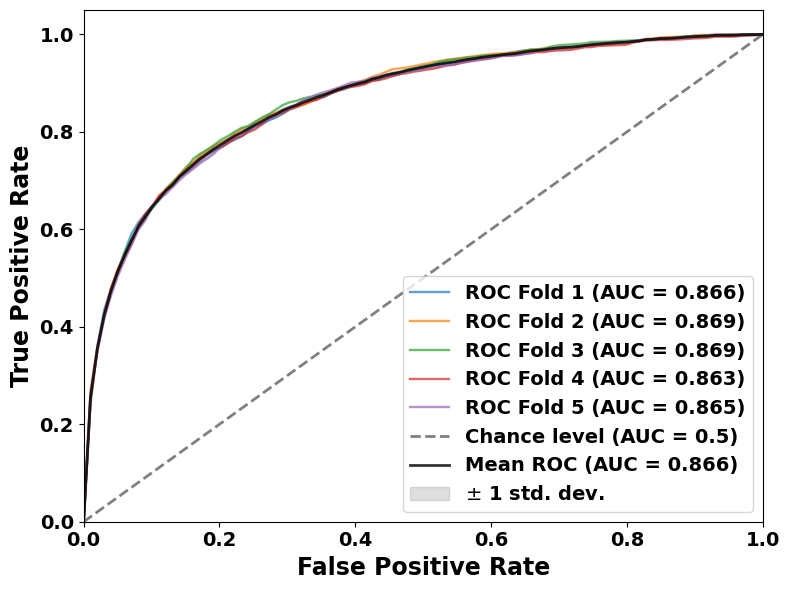

In [53]:
plot_roc_curves(test_preds, test_trues)